# 3_vae_impementation.ipynb
Configurations, training, and result from all Variational Autoencoder (VAE)

### Loading and preparing dataset

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt 
from sklearn.datasets import load_digits 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import joblib
import matplotlib.colors as colors

# Path hack.
import sys, os
sys.path.insert(0, os.path.abspath('..'))
from scripts.data_utils.plots import scatter, visualize_scatter_with_images,plot_similar_image,  plot_random_directions, plot_subset_of_directions 
from scripts.data_utils.generators import SimilarityImageGenerator, generate_directional_dataset, flatten_directional_data
from scripts.data_utils.grid_utils import pad_data_to_fit_patch,blockshaped, unblockshaped, plot_embeddings, plot_patched_directions, create_patched_data


#load  seimsic data
chapterName = "3_vae_impementation"
output_folder = "<insert path>" + chapterName


/home/andykamp/envs/master/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/andykamp/envs/master/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/andykamp/envs/master/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/andykamp/envs/master/lib/python3.7/site-packages/tensorflow/pyth

In [2]:

#load  seimsic data
data_cube = np.load("/home/andykamp/master/quantify_seismic_similarity/data/processed/f3_entire_int8.npy")


print("img shape", data_cube.shape)

directions, inline_samples, xline_samples, tline_samples,data, labels, num_samples, shape = generate_directional_dataset(data_cube)
#print("labels", labels["inline"], labels["xline"], labels["tline"])

img shape (651, 951, 462)
651 951 462


35


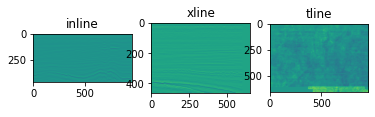

In [3]:


# plt different slices 
plot_random_directions(data, 100)

   

In [4]:
"""
We see that inline and xline directions have clear stacking patterns, 
but the tline is more meshy.

Intuitivly, we would could easily see more clear pattern change in iline/xline direction 
"""

'\nWe see that inline and xline directions have clear stacking patterns, \nbut the tline is more meshy.\n\nIntuitivly, we would could easily see more clear pattern change in iline/xline direction \n'

In [5]:
# but beforre we can do this we need to pad the images to go up in the wanted patch size
patch_size = 64

padding_needed {'inline': 53, 'xline': 9, 'tline': 50}
Found inline
Found xline
Found tline
padded_data (704, 960, 512)
padded_data (960, 704, 512)
padded_data (512, 960, 704)


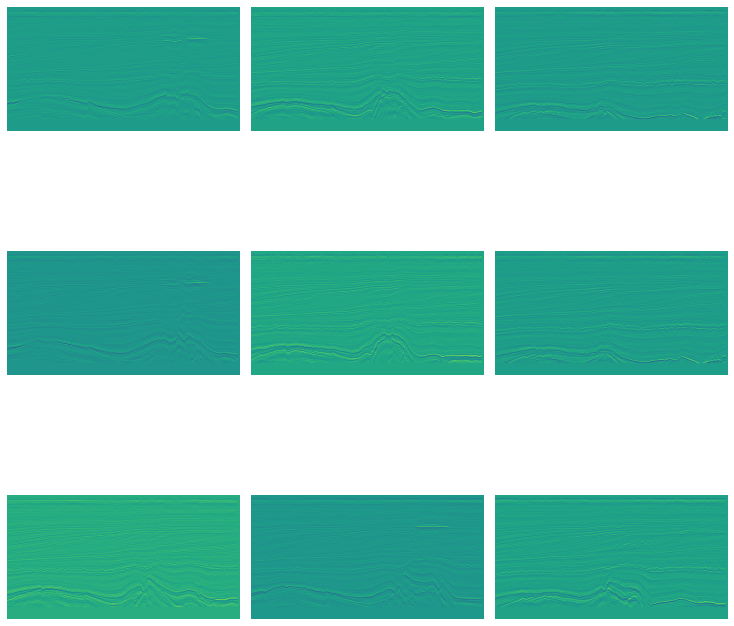

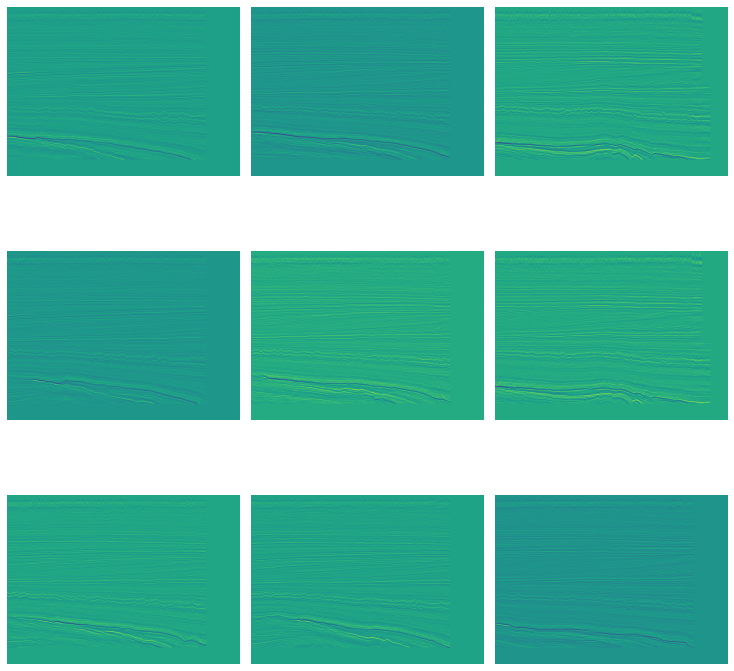

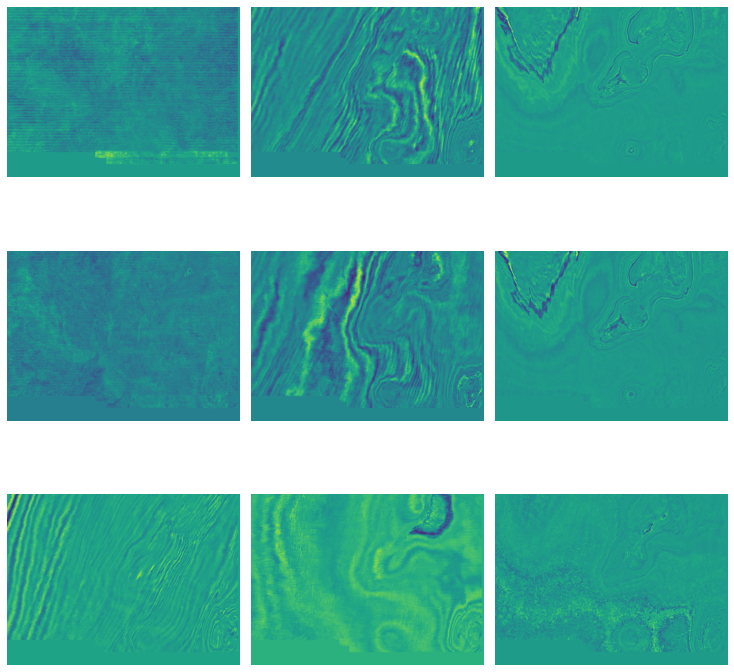

In [6]:
## We then pad each direction to be able to grid it to a 16, 32, 64 ++ grid. 
# The reason we choose such numbers are gupu optimilization (LINK)



padded_data = pad_data_to_fit_patch(data, patch_size, directions, num_samples, output_folder)
for dir in directions:
    print("padded_data", padded_data[dir].shape)
    
# plot supsets of each direction to visualize patterns in each direction
plot_subset_of_directions(padded_data, directions, 100)


In [7]:
# we have now padded all directions and can extract patched of patch_size 

patched_data, patched_labels, patched_labels_per_image, patched_labels_per_grid_cell, patched_labels_per_grid_cell, patched_grid_sizes, patched_num_smaples =  create_patched_data(padded_data, patch_size, directions)



dir shape (704, 960, 512)
nm 15 8 84480
patched_data (84480, 64, 64)
patched_labels[dir] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [84470. 84471. 84472. 84473. 84474. 84475. 84476. 84477. 84478. 84479.]
patched_labels_per_image[dir] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [703. 703. 703. 703. 703. 703. 703. 703. 703. 703.]
patched_labels_per_grid_cell[dir] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [110. 111. 112. 113. 114. 115. 116. 117. 118. 119.]
dir shape (960, 704, 512)
nm 11 8 84480
patched_data (84480, 64, 64)
patched_labels[dir] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [84470. 84471. 84472. 84473. 84474. 84475. 84476. 84477. 84478. 84479.]
patched_labels_per_image[dir] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [959. 959. 959. 959. 959. 959. 959. 959. 959. 959.]
patched_labels_per_grid_cell[dir] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [78. 79. 80. 81. 82. 83. 84. 85. 86. 87.]
dir shape (512, 960, 704)
nm 15 11 84480
patched_data (84480, 64, 64)
patched_labels[dir] [0. 1. 2. 3. 4. 5. 6. 7. 8. 9.] [84470. 84471. 84472. 84473. 84474. 84

random_slice 60360
patched_slice (120, 64, 64)
random_slice 42064
patched_slice (88, 64, 64)
random_slice 58080
patched_slice (165, 64, 64)


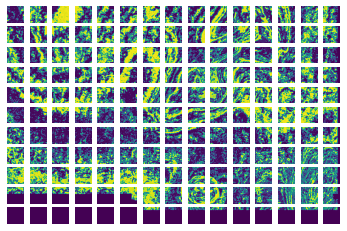

In [8]:
# plot random patches to verify
plot_patched_directions(padded_data, patched_data, patched_grid_sizes, patch_size, directions, output_folder)    
        

In [9]:
### Dimension reduction and visualization with PCA

In [8]:
from scipy.stats import norm

import keras
from keras import layers
from keras.models import Model
from keras import metrics
from keras import backend as K   # 'generic' backend so code works with either tensorflow or theano
from keras.optimizers import RMSprop, Adam, SGD

import numpy as np
import pandas as pd
K.clear_session()
np.random.seed(237)

Using TensorFlow backend.


In [9]:


direction = "inline"
print(patched_data[direction].shape)
data = np.expand_dims(patched_data[direction],axis=-1)
print(data.shape)
length = data.shape[0]//10
val_split = 0.1

# flatten data from (-1, patch_size, patch_size) to  (-1, 4064) 
data = data.reshape(patched_grid_sizes[direction][0], -1)
# find max abs value in data 
max_val = max(abs(np.min(data)),abs(np.max(data))) *0.7 # make sure to clipp sides 
print("abs max ",max_val) # --> outputs 127
# normalize between -1 and 1 
data = data/max_val 
# push first to get values between [0,2] and then devide by 2 to get values between [0,1)]
data = (data + 1) /2
data = np.clip(data, 0, 1)
print("MIN_MAX", np.min(data), np.max(data)) #--> outputs 0 and one 


# reshape to (-1, 64, 64)
data = data.reshape(-1, patch_size, patch_size)

(84480, 64, 64)
(84480, 64, 64, 1)
abs max  88.89999999999999
MIN_MAX 0.0 1.0


In [10]:
print(data.shape)

X_train = data[:1000]#data[:int(length*(1-val_split))]
X_valid = data[:100]#data[int(length*(1-val_split)):]
print(X_train.dtype, np.min(X_train), np.max(X_train))
# Normalize and reshape
X_train = X_train.astype('float32') #/ 255.
X_train = X_train.reshape(-1,patch_size,patch_size,1)

X_valid = X_valid.astype('float32') #/ 255.
X_valid = X_valid.reshape(-1,patch_size,patch_size,1)

print(X_train.shape, X_valid.shape )

(84480, 64, 64)
float64 0.0 1.0
(1000, 64, 64, 1) (100, 64, 64, 1)


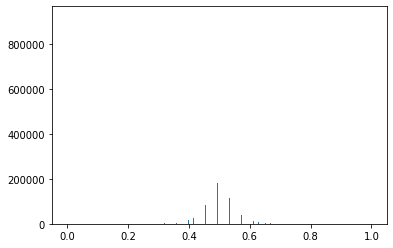

In [11]:
_ = plt.hist(X_train.flatten(), bins='auto')  # arguments are passed to np.histogram
plt.show()

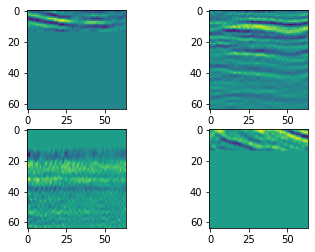

In [12]:
plt.figure(1)
plt.subplot(221)
plt.imshow(X_train[111][:,:,0])

plt.subplot(222)
plt.imshow(X_train[160][:,:,0])

plt.subplot(223)
plt.imshow(X_train[370][:,:,0])

plt.subplot(224)
plt.imshow(X_train[110][:,:,0])
plt.show()

## FIRST WE TRAIN THE ENTIRE NETWORK FOR MEAN, HOLDING VARIANCE CONTANT

In [13]:
img_shape = (patch_size, patch_size, 1)    # for MNIST
batch_size = 16
latent_dim = 2  # Number of latent dimension parameters
intermediate = 512 #1024
# Encoder architecture: Input -> Conv2D*4 -> Flatten -> Dense
input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', 
                  activation='tanh', strides=(2, 2))(input_img)
x = layers.Conv2D(32, 3,
                  padding='same', 
                  activation='tanh',
                  strides=(2, 2))(x)
#x = layers.Conv2D(64, 3,
#                  padding='same', 
#                  activation='tanh')(x)
#x = layers.Conv2D(64, 3,
#                  padding='same', 
#                  activation='tanh')(x)
# need to know the shape of the network here for the decoder
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(intermediate, activation='softplus')(x) # lienar works! relu works find but is not differentiable. softplus is nearly the sme but is smoot than differentiable

# Two outputs, latent mean and (log)variance
z_mu = layers.Dense(latent_dim)(x)
z_log_sigma = layers.Dense(latent_dim)(x)




Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [14]:
### B. Sampling function

In [15]:
# sampling function 
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

# sample vector from the latent distribution
z = layers.Lambda(sampling)([z_mu, z_log_sigma])

encoder = Model(input_img, [z_mu, z_log_sigma, z], name='encoder')
encoder.summary()


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 64, 64, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 32, 32, 32)    320         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 16, 16, 32)    9248        conv2d_1[0][0]                   
____________________________________________________________________________________________________
flatten_1 (Flatten)              (None, 8192)          0           conv2d_2[0][0]                   
__________________________________________________________________________________________

In [16]:
### C. Decoder network

In [17]:
x = layers.Dense(intermediate, activation='tanh')#(z)#(decoder_input)


# Expand to 784 total pixels
xx1 = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='tanh')#(x)#(decoder_input)

# reshape
xx2 = layers.Reshape(shape_before_flattening[1:])#(xx1)

# use Conv2DTranspose to reverse the conv layers from the encoder
xx3 = layers.Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='tanh',
                           strides=(2, 2))#(xx2)
xx4 = layers.Conv2DTranspose(32, 3,
                           padding='same', 
                           activation='tanh',
                           strides=(2, 2))#(xx3)
xx5 = layers.Conv2DTranspose(3, 3,
                           padding='same', 
                           activation='tanh',
                           strides=(1, 1))#(xx4)
_x_decoded_mean = layers.Conv2D(1, 3,
                  name="mean",
                  padding='same', 
                  activation='linear')#(xx5)
_x_decoded_var = layers.Conv2D(1, 3,
                  name="var",
                  padding='same', 
                  activation='softplus')#(xx5) we want to restrict it to only positive numbers, so we use ReLU activation to squash it to our range.

# create decoder structure from z 
#__xx5 = xx5(xx4(xx3(xx2(xx1(x(z))))))
#z_decoded = _x_decoded_mean(__xx5) # used in vae model model       #x_decoded_mean#decoder(z)
#x_decoded_var = _x_decoded_var(__xx5) # used in loss  #x_decoded_mean#decoder(z)
#x_decoded_var.trainable = False




# define decoder as a model for later use 
# decoder takes the latent distribution sample as input
decoder_input = layers.Input(K.int_shape(z)[1:]) # input 
print(decoder_input, K.int_shape(z)[1:], z)

decoder_xx5 = xx5(xx4(xx3(xx2(xx1(x(decoder_input)))))) # shared layers between mean and variance
decoder_ouput_mean = _x_decoded_mean(decoder_xx5) # ouput mean
decoder_ouput_var = _x_decoded_var(decoder_xx5) # ouput var 


# create the actual 
decoder = Model(decoder_input, [decoder_ouput_mean, decoder_ouput_var], name='decoder')
decoder.get_layer("var").trainable = False
for l in decoder.layers:
    print(l.name, l.trainable)
decoder.summary()

# apply the decoder to the sample from the latent distribution to get both mean and var 
z_decoded_mean, z_decoded_var = decoder(encoder(input_img)[2])


Tensor("input_2:0", shape=(?, 2), dtype=float32) (2,) Tensor("lambda_1/add:0", shape=(?, 2), dtype=float32)
input_2 False
dense_4 True
dense_5 True
reshape_1 True
conv2d_transpose_1 True
conv2d_transpose_2 True
conv2d_transpose_3 True
mean True
var False
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 2)             0                                            
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 512)           1536        input_2[0][0]                    
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 8192)          4202496     dense_4[0][0]                    
______________________________________

In [18]:
### D. Loss
#import math
#var_epsilon= 0.010
# construct a custom layer to calculate the loss
#class CustomVariationalLayer(keras.layers.Layer):    
    
#    def logx_loss(self, x, mean, var):
#        loss = (  0.5 * math.log(2 * math.pi)
#                + 0.5 * K.log(var+var_epsilon)  # NOW IT IS STATIC
#                + 0.5 * K.square(x - mean) / ( var+var_epsilon)) # NOW IT IS STATIC
#        loss = K.sum(loss, axis=-1)

#        return K.mean(loss)
    
#    def kl_loss(self,x, mean, var):
#        kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1) # want this to be less originally
#        return K.mean(kl_loss)
    
#    def vae_loss(self, x, mean, var):
#        #x = K.flatten(x)
#        #mean = K.flatten(mean)
#        #var = K.flatten(var)       
#        return self.logx_loss(x, mean, var) + self.kl_loss(x, mean, var)

#    # adds the custom loss to the class
#    def call(self, inputs):
#        x = inputs[0]
#        mean = inputs[1]
#        var = inputs[2]
#        loss = self.vae_loss(x, mean, var)
#        self.add_loss(loss, inputs=inputs)
#        return x

# apply the custom loss to the input images and the decoded latent distribution sample
#y = CustomVariationalLayer()([input_img, z_decoded_mean, z_decoded_var])

#vae_joint = Model(input_img, y)
#vae_joint.compile(optimizer='rmsprop', loss=None)
#vae_joint.summary()

# for loss diskussion see https://github.com/Lasagne/Recipes/issues/54
# loss nnot changing? https://datascience.stackexchange.com/questions/19578/why-my-training-and-validation-loss-is-not-changing
# validating normilization 
#print("MIN_MAX_X_train", np.min(X_train), np.max(X_train)) #--> must be [0,1] 
#print("MIN_MAX_X_valid", np.min(X_valid), np.max(X_valid)) #--> must be [0,1] 

# start training
#history = vae_joint.fit(x=X_train, y=None,
#        shuffle=True,
#        epochs=100,
#        batch_size=16,
#        validation_data=(X_valid, None))

#vae = Model(input_img, z_decoded_mean)


In [19]:
import math
var_epsilon = 0.010
# when using only var__epsilon (static variance) it seems as if the network is better at learning between training points
# this comes to show in the plots far below.
# this is becaus eneural net variance will make eveything more complex, and compressed, and give arbitrary variance inbetweeen 
# as descibed in "goemtric gmanifold paper"

def kl_loss(x, decoder_ouput_mean):
    kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1) # want this to be less originally
   
    return K.mean(kl_loss)

def logx_loss(x, decoder_ouput_mean):
    loss = (  0.5 * math.log(2 * math.pi)
            + 0.5 * K.log(var_epsilon)  # NOW IT IS STATIC use "z_decoded_var" if not static
            + 0.5 * K.square(x - decoder_ouput_mean) / ( var_epsilon)) # NOW IT IS STATIC use "z_decoded_var" if not static
    loss = K.sum(loss, axis=-1)
    #x = K.flatten(x)
    #x_decoded_mean = K.flatten(x_decoded_mean)
    #loss = metrics.binary_crossentropy(x, x_decoded_mean)
    return K.mean(loss)

def vae_loss(x, decoder_ouput_mean):
    return logx_loss(x, decoder_ouput_mean) + kl_loss(x, decoder_ouput_mean)
    #x = K.flatten(x)
    #z_decoded = K.flatten(z_decoded)
    # KL divergence
    #kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1) # want this to be less originally
    # Reconstruction loss
    #xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)# self.logx_loss(x, z_decoded)#

    #return K.mean(xent_loss + kl_loss)



In [20]:
vae = Model(input_img, z_decoded_mean)
vae.compile(optimizer="rmsprop", loss=vae_loss)
vae.summary()
#from keras.utils.vis_utils import plot_model
#plot_path = output_folder +"/model.png"
#print(plot_path)
#plot_model(
#    vae,
#    to_file=plot_path,
#    show_shapes=False,
#    show_layer_names=True,
#    rankdir="TB",
#)


Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 4206436   
_________________________________________________________________
decoder (Model)              [(None, 64, 64, 1), (None 4223451   
Total params: 8,429,887
Trainable params: 8,429,859
Non-trainable params: 28
_________________________________________________________________


In [37]:
# for loss diskussion see https://github.com/Lasagne/Recipes/issues/54
# loss nnot changing? https://datascience.stackexchange.com/questions/19578/why-my-training-and-validation-loss-is-not-changing
# validating normilization 
print("MIN_MAX_X_train", np.min(X_train), np.max(X_train)) #--> must be [0,1] 
print("MIN_MAX_X_valid", np.min(X_valid), np.max(X_valid)) #--> must be [0,1] 

# start training
history = vae.fit(x=X_train, y=X_train,
        shuffle=True,
        epochs=1000,
        batch_size=1000,
        validation_data=(X_valid, X_valid))






MIN_MAX_X_train 0.0 1.0
MIN_MAX_X_valid 0.0 1.0
Train on 80000 samples, validate on 8000 samples
Epoch 1/1000
80000/80000 [==============================] - 11s - loss: -1.2234 - val_loss: -1.2060
Epoch 2/1000
80000/80000 [==============================] - 11s - loss: -1.2355 - val_loss: -1.2076
Epoch 3/1000
80000/80000 [==============================] - 11s - loss: -1.2441 - val_loss: -1.2204
Epoch 4/1000
80000/80000 [==============================] - 11s - loss: -1.2481 - val_loss: -1.2495
Epoch 5/1000
80000/80000 [==============================] - 11s - loss: -1.2517 - val_loss: -1.2497
Epoch 6/1000
80000/80000 [==============================] - 11s - loss: -1.2534 - val_loss: -1.2511
Epoch 7/1000
80000/80000 [==============================] - 11s - loss: -1.2548 - val_loss: -1.2497
Epoch 8/1000
80000/80000 [==============================] - 11s - loss: -1.2566 - val_loss: -1.2356
Epoch 9/1000
80000/80000 [==============================] - 11s - loss: -1.2579 - val_loss: -1.2332
Epo

80000/80000 [==============================] - 11s - loss: -1.2740 - val_loss: -1.2608
Epoch 162/1000
80000/80000 [==============================] - 11s - loss: -1.2742 - val_loss: -1.2612
Epoch 163/1000
80000/80000 [==============================] - 11s - loss: -1.2744 - val_loss: -1.2612
Epoch 164/1000
80000/80000 [==============================] - 11s - loss: -1.2746 - val_loss: -1.2610
Epoch 165/1000
80000/80000 [==============================] - 11s - loss: -1.2748 - val_loss: -1.2616
Epoch 166/1000
80000/80000 [==============================] - 11s - loss: -1.2749 - val_loss: -1.2614
Epoch 167/1000
80000/80000 [==============================] - 11s - loss: -1.2751 - val_loss: -1.2612
Epoch 168/1000
80000/80000 [==============================] - 11s - loss: -1.2753 - val_loss: -1.2615
Epoch 169/1000
80000/80000 [==============================] - 11s - loss: -1.2754 - val_loss: -1.2619
Epoch 170/1000
80000/80000 [==============================] - 11s - loss: -1.2756 - val_loss: -1.

80000/80000 [==============================] - 11s - loss: -1.2870 - val_loss: -1.2747
Epoch 322/1000
80000/80000 [==============================] - 11s - loss: -1.2870 - val_loss: -1.2747
Epoch 323/1000
80000/80000 [==============================] - 11s - loss: -1.2870 - val_loss: -1.2751
Epoch 324/1000
80000/80000 [==============================] - 11s - loss: -1.2871 - val_loss: -1.2753
Epoch 325/1000
80000/80000 [==============================] - 11s - loss: -1.2871 - val_loss: -1.2752
Epoch 326/1000
80000/80000 [==============================] - 11s - loss: -1.2872 - val_loss: -1.2756
Epoch 327/1000
80000/80000 [==============================] - 11s - loss: -1.2872 - val_loss: -1.2754
Epoch 328/1000
80000/80000 [==============================] - 11s - loss: -1.2873 - val_loss: -1.2751
Epoch 329/1000
80000/80000 [==============================] - 11s - loss: -1.2873 - val_loss: -1.2737
Epoch 330/1000
80000/80000 [==============================] - 11s - loss: -1.2873 - val_loss: -1.

80000/80000 [==============================] - 11s - loss: -1.2911 - val_loss: -1.2803
Epoch 482/1000
80000/80000 [==============================] - 11s - loss: -1.2911 - val_loss: -1.2801
Epoch 483/1000
80000/80000 [==============================] - 11s - loss: -1.2911 - val_loss: -1.2803
Epoch 484/1000
80000/80000 [==============================] - 11s - loss: -1.2911 - val_loss: -1.2807
Epoch 485/1000
80000/80000 [==============================] - 11s - loss: -1.2911 - val_loss: -1.2793
Epoch 486/1000
80000/80000 [==============================] - 11s - loss: -1.2912 - val_loss: -1.2802
Epoch 487/1000
80000/80000 [==============================] - 11s - loss: -1.2912 - val_loss: -1.2802
Epoch 488/1000
80000/80000 [==============================] - 11s - loss: -1.2912 - val_loss: -1.2797
Epoch 489/1000
80000/80000 [==============================] - 11s - loss: -1.2912 - val_loss: -1.2805
Epoch 490/1000
80000/80000 [==============================] - 11s - loss: -1.2913 - val_loss: -1.

80000/80000 [==============================] - 11s - loss: -1.2935 - val_loss: -1.2841
Epoch 642/1000
80000/80000 [==============================] - 11s - loss: -1.2934 - val_loss: -1.2835
Epoch 643/1000
80000/80000 [==============================] - 11s - loss: -1.2935 - val_loss: -1.2838
Epoch 644/1000
80000/80000 [==============================] - 11s - loss: -1.2935 - val_loss: -1.2840
Epoch 645/1000
80000/80000 [==============================] - 11s - loss: -1.2935 - val_loss: -1.2839
Epoch 646/1000
80000/80000 [==============================] - 11s - loss: -1.2935 - val_loss: -1.2835
Epoch 647/1000
80000/80000 [==============================] - 11s - loss: -1.2935 - val_loss: -1.2833
Epoch 648/1000
80000/80000 [==============================] - 11s - loss: -1.2936 - val_loss: -1.2830
Epoch 649/1000
80000/80000 [==============================] - 11s - loss: -1.2935 - val_loss: -1.2843
Epoch 650/1000
80000/80000 [==============================] - 11s - loss: -1.2936 - val_loss: -1.

80000/80000 [==============================] - 11s - loss: -1.2951 - val_loss: -1.2864
Epoch 802/1000
80000/80000 [==============================] - 11s - loss: -1.2951 - val_loss: -1.2838
Epoch 803/1000
80000/80000 [==============================] - 11s - loss: -1.2951 - val_loss: -1.2859
Epoch 804/1000
80000/80000 [==============================] - 11s - loss: -1.2951 - val_loss: -1.2862
Epoch 805/1000
80000/80000 [==============================] - 11s - loss: -1.2952 - val_loss: -1.2859
Epoch 806/1000
80000/80000 [==============================] - 11s - loss: -1.2952 - val_loss: -1.2861
Epoch 807/1000
80000/80000 [==============================] - 11s - loss: -1.2951 - val_loss: -1.2861
Epoch 808/1000
80000/80000 [==============================] - 11s - loss: -1.2952 - val_loss: -1.2864
Epoch 809/1000
80000/80000 [==============================] - 11s - loss: -1.2951 - val_loss: -1.2843
Epoch 810/1000
80000/80000 [==============================] - 11s - loss: -1.2952 - val_loss: -1.

80000/80000 [==============================] - 11s - loss: -1.2963 - val_loss: -1.2875
Epoch 962/1000
80000/80000 [==============================] - 11s - loss: -1.2962 - val_loss: -1.2875
Epoch 963/1000
80000/80000 [==============================] - 11s - loss: -1.2963 - val_loss: -1.2876
Epoch 964/1000
80000/80000 [==============================] - 11s - loss: -1.2962 - val_loss: -1.2874
Epoch 965/1000
80000/80000 [==============================] - 11s - loss: -1.2963 - val_loss: -1.2873
Epoch 966/1000
80000/80000 [==============================] - 11s - loss: -1.2963 - val_loss: -1.2867
Epoch 967/1000
80000/80000 [==============================] - 11s - loss: -1.2962 - val_loss: -1.2877
Epoch 968/1000
80000/80000 [==============================] - 11s - loss: -1.2963 - val_loss: -1.2875
Epoch 969/1000
80000/80000 [==============================] - 11s - loss: -1.2963 - val_loss: -1.2874
Epoch 970/1000
80000/80000 [==============================] - 11s - loss: -1.2963 - val_loss: -1.

In [30]:
# store model 
# serialize weights to HDF5
#weight_path = output_folder+"/weight_64x64_2_80000_softplus_varstatic.h5"
#model_path = output_folder+"/model_64x64_2_80000_softplus_varstatic.h5"
weight_path = output_folder+"/weight_64x64_2_1000_softplus_varstatic.h5"
model_path = output_folder+"/model_64x64_2_1000_softplus_varstatic.h5"
#vae.save_weights(weight_path)
#vae.save(model_path)
#print("Saved model to disk")

vae.load_weights(weight_path)
#vae = keras.models.load_model(model_path, custom_objects={'vae_loss': vae_loss}, compile=False)
print("LOADED")
#print(history.history.keys())
#print(history.history["loss"])



LOADED


In [23]:
vae_path = output_folder+"/model_64_64_8x8_1_000_tanh_variance_500epochs.h5"
vae.save(vae_path)

generator_path = output_folder+"/decoder_64_64_8x8_1_000_tanh_variance_500epochs.h5"
decoder.save(generator_path)

# VERIFY MODEL

In [31]:
# X's and Y's
print("Making sure the data is normalzed", np.min(X_train), np.max(X_train))
X_valid_noTest = X_train[:100]
y_valid_noTest = patched_labels_per_image[direction][:100]
print(X_valid_noTest.shape)
# save data for use in other notebooks
#encodeddd,_,_ = encoder.predict(X_train)
#decodeddd,_ = decoder.predict(encodeddd)
#print(X_train.shape, encodeddd.shape, decodeddd.shape)
#np.save( output_folder + "/original_X_train.npy", X_train)
#np.save(output_folder + "/encoded_X_train.npy",encodeddd)
#np.save(output_folder + "/decoded_X_train.npy", decodeddd)

Making sure the data is normalzed 0.0 1.0
(100, 64, 64, 1)


(41, 64, 64, 1)


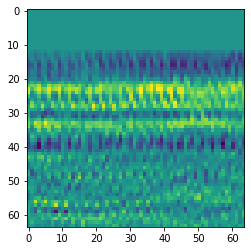

(41, 64, 64, 1)
(41, 64, 64, 1)


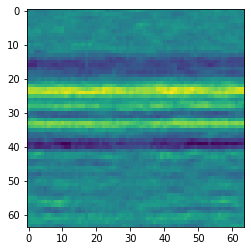

In [32]:
img_samples = X_train[235:276]
print(img_samples.shape)
plt.imshow(img_samples[11][:,:,0])
plt.show()
print(img_samples.shape)
img_decoded = vae.predict(img_samples)
print(img_decoded.shape)
plt.imshow(img_decoded[11][:,:,0])


img samples  0.3031496062992126 0.7418447694038246
img samples  0.32078567 0.6917039
img samples  0.41605195 1.2339605
(5, 64, 64, 1) (5, 64, 64, 1)
(5, 64, 64, 1) (5, 64, 64, 1)


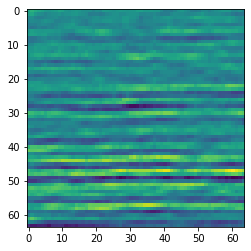

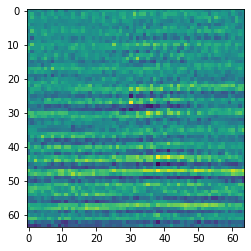

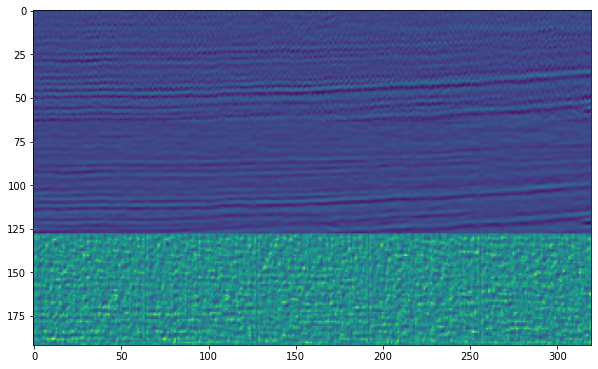

In [34]:
#encoder = Model(input_img, z_mu)
#encoder_var = Model(input_img, z_log_sigma)

#vaeeee = Model(input_img, z_decoded_mean)

num_imgs = 5
img_samples = data[20:20+num_imgs].reshape(-1, 64, 64, 1)
print("img samples ", np.min(img_samples), np.max(img_samples))
#run vae through some of them 
reconstructions_vae = vae.predict(img_samples)
_,reconstructions_enc_dec =decoder.predict(encoder.predict(img_samples)[0])
print("img samples ", np.min(reconstructions_vae), np.max(reconstructions_vae))
print("img samples ", np.min(reconstructions_enc_dec), np.max(reconstructions_enc_dec))

print(reconstructions_vae.shape, reconstructions_enc_dec.shape)
m, v= decoder.predict(encoder.predict(img_samples)[0])
print(m.shape, v.shape)
plt.imshow(m[0][:,:,0])
plt.show()
plt.imshow(img_samples[0][:,:,0])
plt.show()

rec_list = [img_samples, reconstructions_vae, reconstructions_enc_dec]
figure = np.zeros((patch_size * len(rec_list), patch_size * num_imgs))
for i, rec_type in enumerate(rec_list):
    for j in range(num_imgs):
        x_decoded = rec_type[j]
        img = rec_type[j][:,:,0]
        figure[i * patch_size: (i + 1) * patch_size,
               j * patch_size: (j + 1) * patch_size] = img

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()  
#plt.imshow(reconstructions[5].reshape(patch_size, patch_size))
#plt.show()


# DNN VARIANCE NETWORK

In [28]:
# Train the variance network  using DNN 
from keras import activations


# set all layers in the vae to non-trainable 
# need first to set all to trainabel bcause setting trainable on submodel overides lower overwrited
for l in vae.layers[1:]:
    l.trainable = True
    print(l.name, l.trainable)
    
# set encoder to non-trainable 
vae.get_layer("encoder").trainable = False
# set all decoder to non-trainable 
for l in vae.layers[2].layers:
    l.trainable = False
    print(l.name, l.trainable)

# set variance to be traibale 
vae.get_layer("decoder").get_layer("var").trainable = True
#vae.get_layer("decoder").get_layer("var").activation = activations.softplus
for l in vae.layers[2].layers:
    print(l.name, l.trainable)
vae.summary()


# sample vector from the latent distribution
decoder_mean = vae.get_layer("decoder")  
_mean = decoder_mean.layers[-2].output
_var = decoder_mean.layers[-1].output
print("(K.shape(z_mu)[0], 1)", (K.shape(z_mu)[0], 1))
def sampling(args):
    z_mu, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mu)),
                              mean=0., stddev=1.)
    return z_mu + K.exp(z_log_sigma) * epsilon

x_sampled = layers.Lambda(sampling)([_mean, _var])
# create sampled model
y_sampled = Model(inputs=decoder_mean.inputs, outputs=[_mean, _var, x_sampled], name='y_sampled')
y_sampled.summary()

_,_,sampled_ouput = y_sampled(encoder(input_img)[2])
vae = Model(inputs=input_img, outputs=sampled_ouput)

######### RE-STATE LOSS SO WE ONLY TRAIN VARIANCE ####################
import math
var_epsilon = 0.0010
learning_rate = 0.00001
# 𝜖 is a hyperparameter that needs to be small enough to be able to capture the variance 
# of your smallest dimension (bigger variances can be generated by the "ReLU" function).
# Along with this issue, you have to make sure that you're learning rate is small enough to 
# allow your loss function to converge because we're still dividing by potentially small values that can vary widely 

# when using only var__epsilon (static variance) it seems as if the network is better at learning between training points
# this comes to show in the plots far below.
# this is becaus eneural net variance will make eveything more complex, and compressed, and give arbitrary variance inbetweeen 
# as descibed in "goemtric gmanifold paper"

def kl_loss(x, decoder_ouput_mean):
    kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1) # want this to be less originally
   
    return K.mean(kl_loss)

def logx_loss(x, decoder_ouput_mean):
    loss = (  0.5 * math.log(2 * math.pi)
            + 0.5 * K.log(z_decoded_var + var_epsilon)  # NOW IT IS NOOOOT STATIC use "z_decoded_var" if not static
            + 0.5 * K.square(x - decoder_ouput_mean) / (z_decoded_var + var_epsilon)) # NOW IT IS NOOOOT STATIC use "z_decoded_var" if not static
    loss = K.sum(loss, axis=-1)
    return K.mean(loss)

def vae_loss_with_variance(x, decoder_ouput_mean):
    return logx_loss(x, decoder_ouput_mean) + kl_loss(x, decoder_ouput_mean)

# compile model to include loss 
optimizer = Adam(lr=learning_rate)
vae.compile(optimizer=optimizer, loss=vae_loss_with_variance)
vae.summary() 
# fit data to update the variance network weights
vae.fit(x=X_train, y=X_train,
        shuffle=True,
        epochs=1000,
        batch_size=16,
        validation_data=(X_valid, X_valid))


encoder True
decoder True
input_2 False
dense_4 False
dense_5 False
reshape_1 False
conv2d_transpose_1 False
conv2d_transpose_2 False
conv2d_transpose_3 False
mean False
var False
input_2 False
dense_4 False
dense_5 False
reshape_1 False
conv2d_transpose_1 False
conv2d_transpose_2 False
conv2d_transpose_3 False
mean False
var True
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 4206436   
_________________________________________________________________
decoder (Model)              [(None, 64, 64, 1), (None 4223451   
Total params: 8,429,887
Trainable params: 28
Non-trainable params: 8,429,859
_________________________________________________________________
(K.shape(z_mu)[0], 1) (<tf.Tensor 'strided_slice:0' shape=() d

In [72]:
# store model 
# serialize weights to HDF5
weight_path = output_folder+"/dnn_var_weight_64x64_2_1000_softplus_varstatic.h5"
model_path = output_folder+"/dnn_var__model_64x64_2_1000_softplus_varstatic.h5"
#vae.save_weights(weight_path)
#vae.save(model_path)
#print("Saved model to disk")

vae.load_weights(weight_path)
#vae = keras.models.load_model(model_path, custom_objects={'vae_loss': vae_loss}, compile=False)
print("LOADED")
#print(history.history.keys())
#print(history.history["loss"])


LOADED


img samples  0.0 0.8205849268841395
img samples  -6.8212767 9.267889
img samples  0.36831954 1.0626066
(5, 64, 64, 1) (5, 64, 64, 1)
(5, 64, 64, 1) (5, 64, 64, 1)


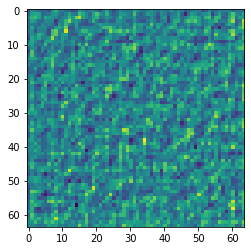

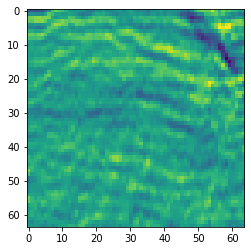

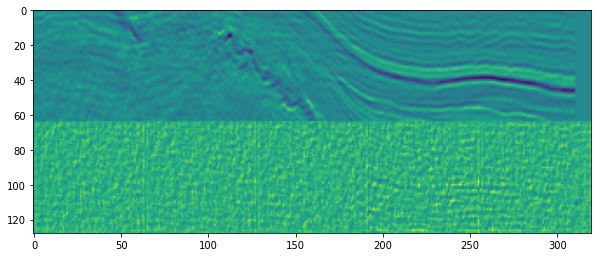

In [29]:

num_imgs = 5
img_samples = data[700:700+num_imgs].reshape(-1, 64, 64, 1)
print("img samples ", np.min(img_samples), np.max(img_samples))
#run vae through some of them 
reconstructions_vae = vae.predict(img_samples)
_,reconstructions_enc_dec =decoder.predict(encoder.predict(img_samples)[0])
print("img samples ", np.min(reconstructions_vae), np.max(reconstructions_vae))
print("img samples ", np.min(reconstructions_enc_dec), np.max(reconstructions_enc_dec))

print(reconstructions_vae.shape, reconstructions_enc_dec.shape)
m, v= decoder.predict(encoder.predict(img_samples)[0])
print(m.shape, v.shape)
plt.imshow(v[0][:,:,0])
plt.show()
plt.imshow(img_samples[0][:,:,0])
plt.show()

rec_list = [img_samples, reconstructions_enc_dec]
figure = np.zeros((patch_size * len(rec_list), patch_size * num_imgs))
for i, rec_type in enumerate(rec_list):
    for j in range(num_imgs):
        x_decoded = rec_type[j]
        img = rec_type[j][:,:,0]
        figure[i * patch_size: (i + 1) * patch_size,
               j * patch_size: (j + 1) * patch_size] = img

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()  

# RBF

In [39]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.engine.topology import Layer
from keras.initializers import RandomUniform, Initializer, Constant
from keras.losses import binary_crossentropy
from keras.optimizers import RMSprop
from scripts.rbf.rbf import InitCentersKMeans, InitCentersRandom, RBFLayer
from tensorflow.keras.constraints import NonNeg

import tensorflow as tf

# provide the encoded data that the new rbf encoder needs to fit to 
# this data is the entire reason why we cannot build it and freeze it in the initial network 
X,_,_ = encoder.predict(X_train) # pca_model.transform(X_recon)
print(X.shape)

(1000, 2)


# RBF NETWORK TEST

shapes 2 2
inside initiationrandom (350, 2)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
rbf (RBFLayer)               (None, 350)               1050      
_________________________________________________________________
rb_dense (Dense)             (None, 1)                 351       
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
_________________________________________________________________
(1000,)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Train on 1000 samples, validate on 1000 samples
Epoch 1/10
1000/1000 [==============================] - 0s - loss: 0.9585 - val_loss: 0.8735

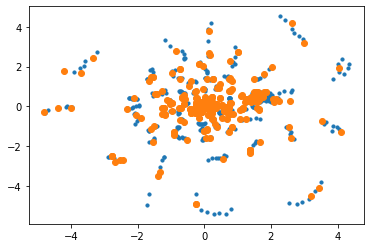

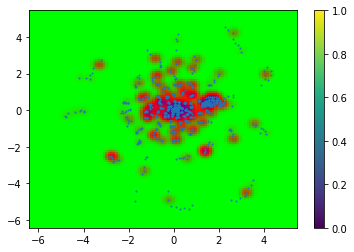

In [29]:


######### FIT PCA ####################
use_pca = False
if use_pca:
    from sklearn.decomposition import PCA
    X_reshape = X.reshape((X.shape[0], -1))
    print(X_reshape.shape)
    n_components = 2
    pca_model=PCA(n_components)
    pca = pca_model.fit_transform(X_reshape) 
    print(np.sum(pca_model.explained_variance_ratio_))

    plt.scatter(pca[:,0], pca[:, 1])
    project_first = False
    if project_first:
        X = pca
        
plt.scatter(X[:,0], X[:, 1], s=10)

#print(X.shape)
######### CREATE RBF NETWORK ####################
rbf_decoder_input = layers.Input((X.shape[-1],)) # input 

rbflayer = RBFLayer(350,
                    name="rbf",
                    initializer=InitCentersRandom(X),
                    betas=20, # determine the sharpness of the gausian https://towardsdatascience.com/most-effective-way-to-implement-radial-basis-function-neural-network-for-classification-problem-33c467803319
                    input_shape=(X.shape[-1],))

#rbfoutput = layers.Dense(1024, name="rb_dense", activation='linear',kernel_constraint=NonNeg(), bias_constraint=NonNeg())
rbfoutput = layers.Dense(1, name="rb_dense", activation='linear',kernel_constraint=NonNeg(), bias_constraint=NonNeg())

rbf_network = Model(inputs=rbf_decoder_input, outputs=rbfoutput(rbflayer(rbf_decoder_input)))
rbf_network.summary() 



######### PCA EMBEDDINGS TO 2 DIMS--> THEN TRAIN  ####################
learning_rate = 0.0001
optimizer = Adam(lr=learning_rate)
rbf_network.compile(optimizer=optimizer, loss='mean_squared_error')
print(np.zeros((X.shape[0],)).shape)
rbf_network.fit(x=X, y=np.ones((X.shape[0],)),
        shuffle=True,
        epochs=10,
        batch_size=16,
        validation_data=(X, np.ones((X.shape[0],))))



h = 0.11
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
end = max(x_max, y_max)
start =  min(x_min, y_min)
xx, yy = np.meshgrid(np.arange(start, end, h),
                    np.arange(start, end, h))

print(xx.shape, yy.shape)
grid_inp = np.c_[xx.ravel(), yy.ravel()]
if use_pca:
    if project_first:
        grid_latent = grid_inp
    else: grid_latent = pca_model.inverse_transform(grid_inp)
else: grid_latent = grid_inp
grid_latent_pred = rbf_network.predict(grid_latent)
print("PRED_SHAPE", grid_latent_pred.shape)
# project back 
grid_latent_pred = grid_latent_pred.reshape(xx.shape)
print(grid_latent_pred.shape)
print("MAXMIN", grid_latent_pred.min(), grid_latent_pred.max())
plt.figure()
#plt.imshow(grid_latent_pred)# norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),)
plt.pcolormesh(xx, yy, np.log10(1/grid_latent_pred), cmap="brg")# norm=colors.LogNorm(vmin=grid_latent_pred.min(), vmax=grid_latent_pred.max()),)
plt.scatter(X[:,0], X[:, 1], s=1)

plt.colorbar()
plt.show()


######### PCA EMBEDDINGS TO 2 DIMS--> THEN TRAIN  ####################



# RBF VARIANCE NETWORK 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 4206436   
_________________________________________________________________
decoder (Model)              [(None, 64, 64, 1), (None 4223451   
Total params: 8,429,887
Trainable params: 0
Non-trainable params: 8,429,887
_________________________________________________________________
input_2 False
dense_4 False
dense_5 False
reshape_1 False
conv2d_transpose_1 False
conv2d_transpose_2 False
conv2d_transpose_3 False
mean False
num clusters (350, 2)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)        

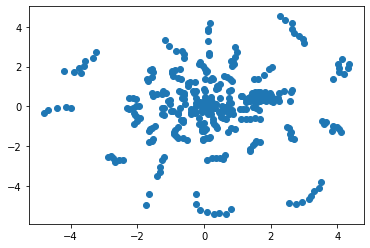

In [40]:



    

######### CREATE RBF VARIANCE NETWORK ####################
rbf_decoder_input = layers.Input(K.int_shape(z)[1:]) # input 

rbflayer = RBFLayer(350,
                    name="rbf",
                    initializer=InitCentersKMeans(X),#InitCentersRandom(X),
                    betas=20, # determine the sharpness of the gausian https://towardsdatascience.com/most-effective-way-to-implement-radial-basis-function-neural-network-for-classification-problem-33c467803319
                    input_shape=(latent_dim,))
#model.add(rbflayer)
#model.add(Dense(2, activation='sigmoid', name='foo'))
#model.add(Dense(1, activation='sigmoid', ))

#model.add(Dense(64, name='foo'))
# reshape
rbfoutput = layers.Dense(1024, name="rb_dense", activation='linear',kernel_constraint=NonNeg(), bias_constraint=NonNeg())#activation='tanh')#(z)#(decoder_input)
reshapelayer = layers.Reshape((32,32,1)) # subsampled image of 64*64  (i guess)
convT1 = layers.Conv2DTranspose(1, 3,
                           padding='same', #TODO NEED TO CLIP WEIGHT SO IT IS POSITIVE
                           activation='linear',
                           strides=(2, 2),
                           kernel_constraint=NonNeg(), bias_constraint=NonNeg())
#convT2 = layers.Conv2DTranspose(1, 3,
#                           padding='same', #TODO NEED TO CLIP WEIGHT SO IT IS POSITIVE
#                           activation='tanh',
#                           strides=(2, 2),
#                           kernel_constraint=NonNeg(), bias_constraint=NonNeg())
#convT3 = layers.Conv2DTranspose(1, 3,
#                           padding='same',  #TODO NEED TO CLIP WEIGHT SO IT IS POSITIVE
#                           activation='tanh',
#                           strides=(2, 2),
#                           kernel_constraint=NonNeg(), bias_constraint=NonNeg())
conv = layers.Conv2D(1, 3,
                     name="var",
                  padding='same', 
                  activation='linear', strides=(1, 1),
                  kernel_constraint=NonNeg(), bias_constraint=NonNeg())

#### 
#centers = rbflayer.get_weights()[0]
#widths = rbflayer.get_weights()[1]
#print("RBFWEIGHTS", centers.shape, widths.shape, widths[:10])
           
    
######### CREATE NEW RBF DECODER ####################

# create duplicate of old decoder but remove variance network

#print(decoder.inputs,rbf_decoder_input )
#decoder_mean_layers = [layer.output for layer in decoder.layers]
#for l in decoder_mean_layers:
#    l.trainable = False
#    print(l.name, l.trainable)    
#rbf_output_mean, _ = Model(inputs=rbf_decoder_input,outputs=decoder_mean_layers)


# set all layers in the vae to non-trainable 
# need first to set all to trainabel bcause setting trainable on submodel overides lower overwrited
for l in vae.layers[1:]:
    l.trainable = True
    
# set encoder to non-trainable 
vae.get_layer("encoder").trainable = False
# set all decoder to non-trainable 
for l in vae.layers[2].layers:
    l.trainable = False
# verify no layers are trainable
vae.summary()

# create non-trainable mean-network from existing
decoder_mean = vae.get_layer("decoder")
mean_network = Model(inputs=decoder_mean.inputs, outputs=decoder_mean.layers[-2].output,name='mean_network')## decoder(rbf_decoder_input)
for l in mean_network.layers:
    l.trainable = False
    print(l.name, l.trainable)
rbf_output_mean= mean_network(rbf_decoder_input)

# create new rb network 
rbf_network = rbfoutput(rbflayer(rbf_decoder_input))
rbf_output_var = conv(convT1(reshapelayer(rbf_network)))

# add both as a model 
rbf_decoder = Model(rbf_decoder_input, [rbf_output_mean, rbf_output_var],name='decoder')
rbf_decoder.summary()
print("RBF ENCODER")
for l in rbf_decoder.layers:
    l.trainable = True
    print(l.name, l.trainable)   
# set encoder to non-trainable 
rbf_decoder.get_layer("mean_network").trainable = False
rbf_decoded_mean, rbf_decoded_var = rbf_decoder(encoder(input_img)[2]) ##### COMMMENT FOR SAMPLING #####


##### UNCOMMMENT FOR SAMPLING #####
# sample vector from the latent distribution
#print("(K.shape(z_mu)[0], 1)", (K.shape(z_mu)[0], 1))
#def sampling(args):
#    z_mu, z_log_sigma = args
#    epsilon = K.random_normal(shape=(K.shape(z_mu)),
#                              mean=0., stddev=1.)
#    return z_mu + K.exp(z_log_sigma) * epsilon

#x_sampled = layers.Lambda(sampling)([rbf_output_mean, rbf_output_var])
# create sampled model
#y_sampled = Model(inputs=rbf_decoder.inputs, outputs=[rbf_output_mean, rbf_output_var, x_sampled], name='y_sampled')
#print("RBF ENCODER")
#for l in y_sampled.layers:
#    l.trainable = True
#    print(l.name, l.trainable)   
# set encoder to non-trainable 
#y_sampled.get_layer("mean_network").trainable = False
#y_sampled.summary()
#_,rbf_output_var,sampled_ouput = y_sampled(encoder(input_img)[2])
################################# 
    
    
######### RE-STATE LOSS SO WE ONLY TRAIN RBF ####################
import math
var_epsilon = 0.00010
learning_rate = 0.00001
# when using only var__epsilon (static variance) it seems as if the network is better at learning between training points
# this comes to show in the plots far below.
# this is becaus eneural net variance will make eveything more complex, and compressed, and give arbitrary variance inbetweeen 
# as descibed in "goemtric gmanifold paper"

def kl_loss(x, rbf_decoded_mean):
    kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1) # want this to be less originally
   
    return K.mean(kl_loss)

def logx_loss(x, rbf_decoded_mean):
    loss = (  0.5 * math.log(2 * math.pi)
            + 0.5 * K.log(rbf_decoded_var +  var_epsilon)  ##### change to rbf_output_var FOR SAMPLING #####
            + 0.5 * K.square(x - rbf_decoded_mean) / (rbf_decoded_var +  var_epsilon)) ##### change to rbf_output_var FOR SAMPLING #####

    loss = K.sum(loss, axis=-1)
    #x = K.flatten(x)
    #x_decoded_mean = K.flatten(x_decoded_mean)
    #loss = metrics.binary_crossentropy(x, x_decoded_mean)
    return K.mean(loss)

def rbf_vae_loss_with_variance(x, rbf_decoded_mean):
    return logx_loss(x, rbf_decoded_mean) + kl_loss(x, rbf_decoded_mean)
    #x = K.flatten(x)
    #z_decoded = K.flatten(z_decoded)
    # KL divergence
    #kl_loss = -5e-4 * K.mean(1 + z_log_sigma - K.square(z_mu) - K.exp(z_log_sigma), axis=-1) # want this to be less originally
    # Reconstruction loss
    #xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)# self.logx_loss(x, z_decoded)#

    #return K.mean(xent_loss + kl_loss)

######### CREATE NEW RBF VAE ####################

vae = Model(input_img, rbf_decoded_mean)
#vae = Model(inputs=input_img, outputs=sampled_ouput)##### UNCOMMMENT FOR SAMPLING #####


# load the weights if it has not been loaded already....
#filename =output_folder+"/model_64_64_8x8_1_000_tanh_variance_static.h5"
#rbf_vae.load_weights(filename)

# compile model to include loss 
optimizer = Adam(lr=learning_rate)
vae.compile(optimizer=optimizer, loss=rbf_vae_loss_with_variance)
vae.summary() 
# fit data to update the variance network weights
vae.fit(x=X_train, y=X_train,
        shuffle=True,
        epochs=10,
        batch_size=16,
        validation_data=(X_valid, X_valid))

In [41]:
# store model 
# serialize weights to HDF5
#weight_path = output_folder+"/rbf350_weight_64x64_2_80000_softplus_varstatic.h5"
#model_path = output_folder+"/rbf350_model_64x64_2_80000_softplus_varstatic.h5"
weight_path = output_folder+"/rbf350_weight_64x64_2_1000_softplus_varstatic.h5"
model_path = output_folder+"/rbf350_model_64x64_2_1000_softplus_varstatic.h5"
#vae.save_weights(weight_path)
#vae.save(model_path)
#print("Saved model to disk")
#model_json = vae.to_json()
#with open(model_path, "w") as json_file:
#    json_file.write(model_json)
vae.load_weights(weight_path)
#vae = keras.models.load_model(model_path, custom_objects={'vae_loss': vae_loss}, compile=False)
print("LOADED")
#print(history.history.keys())
#print(history.history["loss"])



LOADED


rbf badwidths [19.999952 20.08293  20.045347 20.050667 20.025974 20.063276 20.026285
 20.052073 20.033169 20.037045]
img samples  0.0 0.8205849268841395
img samples  0.04336992 0.77897644
img samples  1.2575393e-15 0.20371157
(5, 64, 64, 1) (5, 64, 64, 1)
(5, 64, 64, 1) (5, 64, 64, 1)


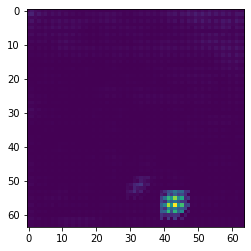

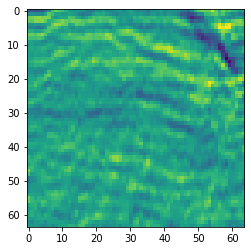

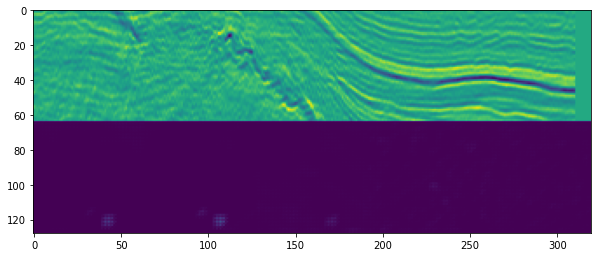

In [42]:
print("rbf badwidths", rbf_decoder.layers[1].get_weights()[1][:10])

num_imgs = 5
img_samples = data[700:700+num_imgs].reshape(-1, 64, 64, 1)
print("img samples ", np.min(img_samples), np.max(img_samples))
#run vae through some of them 
reconstructions_vae = vae.predict(img_samples)
_,reconstructions_enc_dec =rbf_decoder.predict(encoder.predict(img_samples)[0])
print("img samples ", np.min(reconstructions_vae), np.max(reconstructions_vae))
print("img samples ", np.min(reconstructions_enc_dec), np.max(reconstructions_enc_dec))

print(reconstructions_vae.shape, reconstructions_enc_dec.shape)
m, v= rbf_decoder.predict(encoder.predict(img_samples)[0])
print(m.shape, v.shape)
plt.imshow(v[0][:,:,0])
plt.show()
plt.imshow(img_samples[0][:,:,0])
plt.show()

rec_list = [img_samples, reconstructions_enc_dec]
figure = np.zeros((patch_size * len(rec_list), patch_size * num_imgs))
for i, rec_type in enumerate(rec_list):
    for j in range(num_imgs):
        x_decoded = rec_type[j]
        img = rec_type[j][:,:,0]
        figure[i * patch_size: (i + 1) * patch_size,
               j * patch_size: (j + 1) * patch_size] = img

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()  

In [43]:
img_rows, img_cols, img_chns = patch_size, patch_size, 1


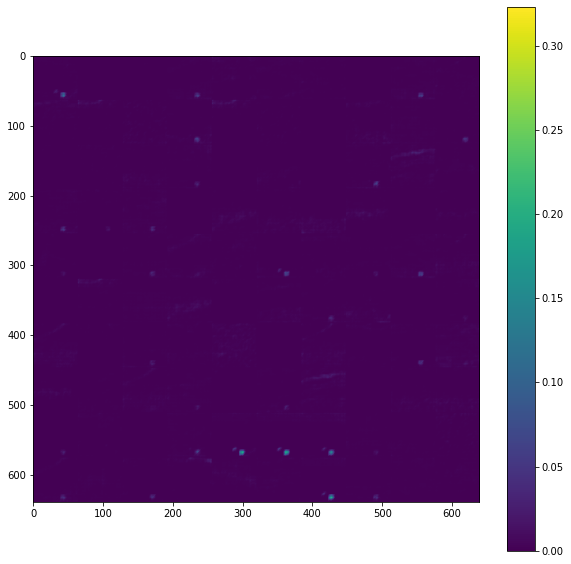

In [44]:
# plot random reconstructions 
n = 10

figure = np.zeros((img_rows * n, img_cols * n))

for i in range(n):
    for j in range(n):
        z_sample = np.random.normal(size=latent_dim).reshape(1, latent_dim)
        #print(z_sample.shape)
        _,x_recon = rbf_decoder.predict(z_sample, batch_size=1)#generator.predict(z_sample, batch_size=1)
        #print(x_recon.shape)
        patch = x_recon.reshape(patch_size, patch_size)
        #print(patch.shape)
        d_x = i * patch_size
        d_y = j * patch_size
        figure[d_x:d_x + patch_size, d_y:d_y + patch_size] = patch

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.colorbar()
plt.show()

In [45]:
from matplotlib import offsetbox
import cv2

def plot_components(proj, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    """ Plots thumb_frac number of original proj as thumbnails images over a scatterplot for visualization"""
    ax = ax or plt.gca()
    
    #ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(proj.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(cv2.resize(images[i].T,  dsize=(32, 32), interpolation=cv2.INTER_CUBIC), cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)
    return ax
            
            


(1000, 64, 64, 1)
found data. loading it to memory
Done trainig pca 
num_labelsss 999 999.0
Plottting:  tline


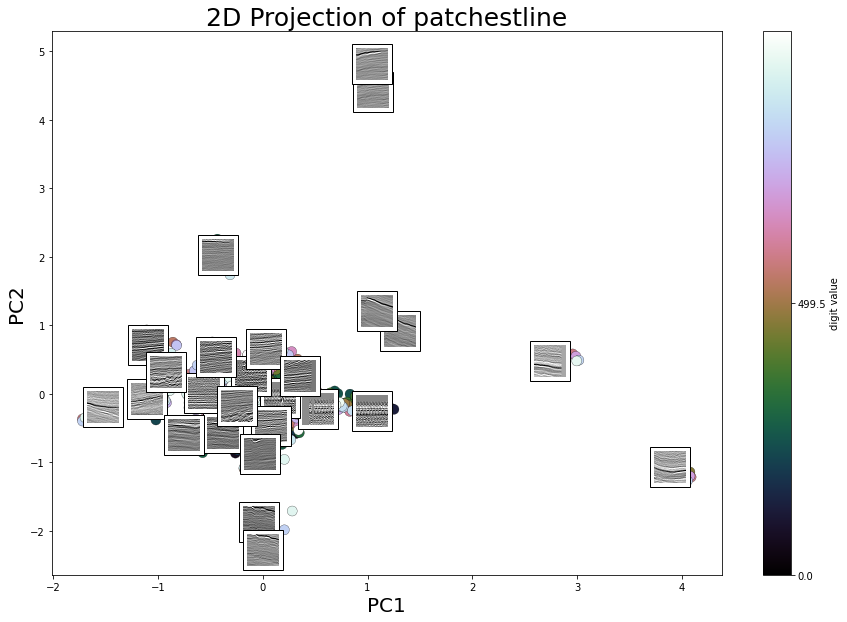

In [46]:
### PLOT ORG IMAHES
from sklearn.decomposition import PCA
print(X_train.shape)
shape = X_train.shape
filename = output_folder + "/pca_embedded_org.npy"
if not os.path.exists(filename):
    print("did not find data.. creating new...")
   
    X_reshape = X_train.reshape((shape[0], -1))
    print(X_reshape.shape)
    n_components = 2
    pca_digits=PCA(n_components)
    pca = pca_digits.fit_transform(X_reshape) 
    print(np.sum(pca_digits.explained_variance_ratio_))
    # store the data 
    np.save(filename, pca)
else:
    print("found data. loading it to memory")
    pca = np.load(filename)
    
print("Done trainig pca ")

# Perform pca  and plot scatterplot of it 
labelss = patched_labels[direction][:shape[0]]
num_labelss = int(np.max(labelss))
print("num_labelsss", num_labelss, labelss[-1])
filename = output_folder + "/pca_" + dir + ".png"
scatter(pca, labelss, num_labelss, dir, show_labels=False, output=filename) 


# Plot acutal images on scatterplot
print("Plottting: ", dir)
images = X_train
plot_components(proj=pca,images=[np.reshape(i, (patch_size, patch_size)).T for i in images])

X_train shape:  (1000, 64, 64, 1)
X_recon shape:  (1000, 2)
Done trainig pca 
num_labelsss 999 999.0
Plottting:  tline
z_sample (1, 2)
z_sample_decoded (1, 64, 64, 1)
z_sample (1, 2)
z_sample_decoded (1, 64, 64, 1)
z_sample (1, 2)
z_sample_decoded (1, 64, 64, 1)
z_sample (1, 2)
z_sample_decoded (1, 64, 64, 1)
z_sample (1, 2)
z_sample_decoded (1, 64, 64, 1)
z_sample (1, 2)
z_sample_decoded (1, 64, 64, 1)
z_sample (1, 2)
z_sample_decoded (1, 64, 64, 1)
z_sample (1, 2)
z_sample_decoded (1, 64, 64, 1)


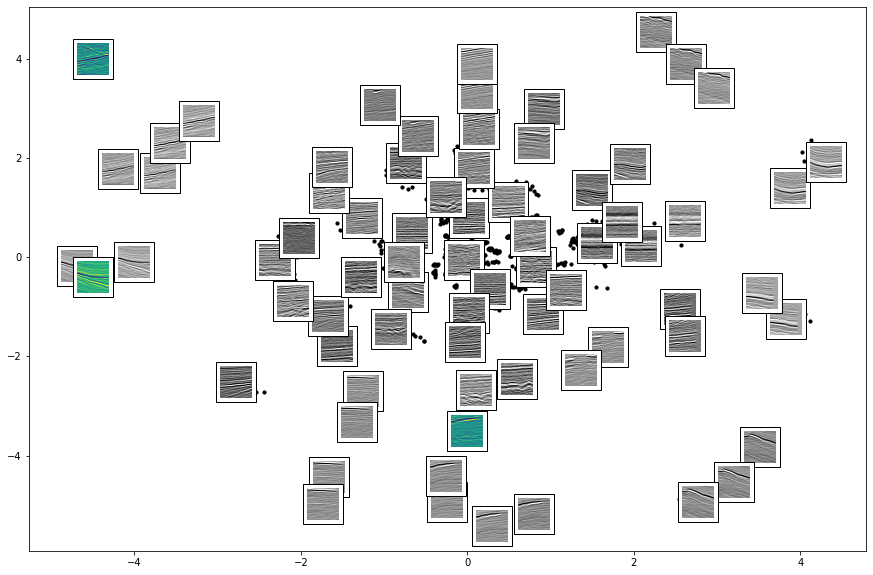

In [57]:
### PLOT ENCODING OF ORGINAL IMAGES ALONG WITH RECONSTRUCTION 
# Here we hope for more meaningful variance 
from sklearn.decomposition import PCA
shape = X_train.shape
print( "X_train shape: ", shape)

X_recon,_,_ =encoder.predict(X_train)
print( "X_recon shape: ",X_recon.shape)
use_pca = False
if use_pca:
    filename = output_folder + "/pca_embedded.npy"
    pca_model_filename = output_folder + "/pca_model.npy"

    if not os.path.exists(filename):
        print("did not find data.. creating new...")

        X_reshape = X_recon.reshape((shape[0], -1))
        print(X_reshape.shape)
        n_components = 2
        pca_model=PCA(n_components)
        pca = pca_model.fit_transform(X_reshape) 
        print(np.sum(pca_model.explained_variance_ratio_))
        # store the data 
        #np.save(filename, pca)
        #print('Dumping pca model to: %s' % (pca_model_filename)) 
        #joblib.dump(pca_model, pca_model_filename)
    else:
        print("found data. loading it to memory")
        pca = np.load(filename)
        pca_model = joblib.load(pca_model_filename)
else:
    pca=X_recon
    
print("Done trainig pca ")

# Perform pca  and plot scatterplot of it 
labelss = patched_labels[direction][:shape[0]]
num_labelss = int(np.max(labelss))
print("num_labelsss", num_labelss, labelss[-1])
filename = output_folder + "/pca.png"
#scatter(pca, labelss, num_labelss, dir, show_labels=False, output=filename) 
plt.figure(figsize=(15,10))
plt.scatter(pca[:, 0], pca[:, 1], s=10,color="black")


# Plot acutal images on scatterplot
print("Plottting: ", dir)
#random_indexes = np.random.choice(shape[0], 100)
#print("random_indexes", random_indexes)
images,_ = decoder.predict(X_recon)
ax = plot_components(proj=pca,images=[np.reshape(i, (patch_size, patch_size)).T for i in images])
# now i can chooose a point in the 2d space, inverse pca transform it and decode it to se how it looks betweeen training data

# show a random generated image
def add_image(coord):
    z_sample = coord.reshape(1, -1)#pca_model.inverse_transform(coord).reshape(1, -1)
    print("z_sample", z_sample.shape)
    z_sample_decoded,_ = rbf_decoder.predict(z_sample)
    print("z_sample_decoded", z_sample_decoded.shape)
    img_decoded = z_sample_decoded.reshape(patch_size, patch_size)
    #plt.imshow(img_decoded)
    #plt.show()
    imagebox=offsetbox.AnnotationBbox(offsetbox.OffsetImage(cv2.resize(img_decoded,  dsize=(32, 32), interpolation=cv2.INTER_CUBIC)), coord)
    ax.add_artist(imagebox)


coord = np.asarray([-4.5,-.4])
add_image(coord)

coord = np.asarray([-4.5,-6.0])
add_image(coord)


coord = np.asarray([-4.5,4])
add_image(coord)


coord = np.asarray([7,-2.5])
add_image(coord)

coord = np.asarray([5.5,1])
add_image(coord)

coord = np.asarray([5.5,5])
add_image(coord)

coord = np.asarray([0,6])
add_image(coord)

coord = np.asarray([0, -3.5])
add_image(coord)





X_train shape:  (1000, 64, 64, 1)
X_recon shape:  (1000, 2)
Done trainig pca 
num_labelsss 999 999.0
Plottting:  tline


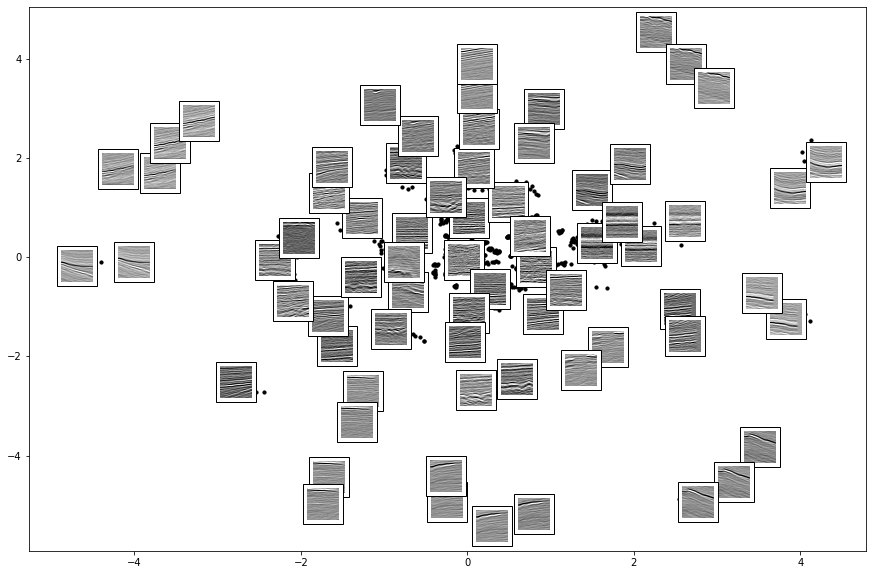

In [53]:
### PLOT ENCODING OF ORGINAL IMAGES ALONG WITH RECONSTRUCTION 
# Here we hope for more meaningful variance 
from sklearn.decomposition import PCA
shape = X_train.shape
print( "X_train shape: ", shape)
label = "VAE"
X_recon,_,_ =encoder.predict(X_train)
print( "X_recon shape: ",X_recon.shape)
use_pca = False
if use_pca:
    filename = output_folder + "/pca_embedded.npy"
    pca_model_filename = output_folder + "/pca_model.npy"

    if not os.path.exists(filename):
        print("did not find data.. creating new...")

        X_reshape = X_recon.reshape((shape[0], -1))
        print(X_reshape.shape)
        n_components = 2
        pca_model=PCA(n_components)
        pca = pca_model.fit_transform(X_reshape) 
        print(np.sum(pca_model.explained_variance_ratio_))
        # store the data 
        #np.save(filename, pca)
        #print('Dumping pca model to: %s' % (pca_model_filename)) 
        #joblib.dump(pca_model, pca_model_filename)
    else:
        print("found data. loading it to memory")
        pca = np.load(filename)
        pca_model = joblib.load(pca_model_filename)
else:
    pca=X_recon
    
print("Done trainig pca ")

# Perform pca  and plot scatterplot of it 
labelss = patched_labels[direction][:shape[0]]
num_labelss = int(np.max(labelss))
print("num_labelsss", num_labelss, labelss[-1])
filename = output_folder + "/pca.png"
plt.figure(figsize=(15,10))
plt.scatter(pca[:, 0], pca[:, 1], s=10,color="black")
#scatter(pca, labelss, num_labelss, dir, show_labels=False, output=filename) 
filename_plot = output_folder + "/" + label +"_"+ dir + "_"+ str(patch_size) 
plt.savefig(filename_plot)

# Plot acutal images on scatterplot
print("Plottting: ", dir)
#random_indexes = np.random.choice(shape[0], 100)
#print("random_indexes", random_indexes)
images,_ = decoder.predict(X_recon)
ax = plot_components(proj=pca,images=[np.reshape(i, (patch_size, patch_size)).T for i in images])
# now i can chooose a point in the 2d space, inverse pca transform it and decode it to se how it looks betweeen training data
filename_plot = output_folder + "/" + label +"_"+ dir + "_"+ str(patch_size) + "_thumbnail"
plt.savefig(filename_plot)
# show a random generated image
def add_image(coord):
    z_sample = coord.reshape(1, -1)#pca_model.inverse_transform(coord).reshape(1, -1)
    print("z_sample", z_sample.shape)
    z_sample_decoded,_ = rbf_decoder.predict(z_sample)
    print("z_sample_decoded", z_sample_decoded.shape)
    img_decoded = z_sample_decoded.reshape(patch_size, patch_size)
    #plt.imshow(img_decoded)
    #plt.show()
    imagebox = offsetbox.AnnotationBbox(offsetbox.OffsetImage(img_decoded), coord)
    ax.add_artist(imagebox)



In [40]:
# Now we have a vae, we can calculate the latent space riemann 

from scripts.riemannian.riemannian_latent_space import RiemannianMetric, RiemannianTree
from scripts.rbf.rbf import InitCentersKMeans, InitCentersRandom, RBFLayer

import tensorflow as tf
import keras 
from scipy.stats import norm


#generator_path = output_folder+"/decoder_64_64_8x8_1_000_tanh_variance_500epochs.h5"
#decoder = keras.models.load_model(generator_path)

filename = output_folder + "/pca_embedded.npy"
pca_model_filename = output_folder + "/pca_model.npy"

if not os.path.exists(filename):
    print("did not find data.. creating new...")
   
    X_reshape = X_recon.reshape((shape[0], -1))
    print(X_reshape.shape)
    n_components = 2
    pca_model=PCA(n_components)
    pca = pca_model.fit_transform(X_reshape) 
    print(np.sum(pca_model.explained_variance_ratio_))
    # store the data 
    np.save(filename, pca)
    print('Dumping pca model to: %s' % (pca_model_filename)) 
    joblib.dump(pca_model, pca_model_filename)
else:
    print("found data. loading it to memory")
    pca = np.load(filename)
    pca_model = joblib.load(pca_model_filename)
    
#latent_dim = 512
batch_size = 16

found data. loading it to memory


z_sampel (1, 2)
x_decoded.shape (1, 64, 64, 1)
Tensor("input_4:0", shape=(?, 2), dtype=float32) Tensor("mean_network/mean/BiasAdd:0", shape=(?, ?, ?, 1), dtype=float32)
Tensor("strided_slice:0", shape=(?,), dtype=float32) Tensor("mean_network/mean/BiasAdd:0", shape=(?, ?, ?, 1), dtype=float32)
num_layer (?, 2) (?, ?, 1)

Done

nklnlnnkl Tensor("mean_network/mean/BiasAdd:0", shape=(?, ?, ?, 1), dtype=float32) Tensor("input_4:0", shape=(?, 2), dtype=float32)
dsfsdsdfds Tensor("strided_slice_3:0", shape=(?, ?, 1), dtype=float32) Tensor("input_4:0", shape=(?, 2), dtype=float32)
nklnlnnkl Tensor("var_1/BiasAdd:0", shape=(?, ?, ?, 1), dtype=float32) Tensor("input_4:0", shape=(?, 2), dtype=float32)
dsfsdsdfds Tensor("strided_slice_68:0", shape=(?, ?, 1), dtype=float32) Tensor("input_4:0", shape=(?, 2), dtype=float32)
doneee


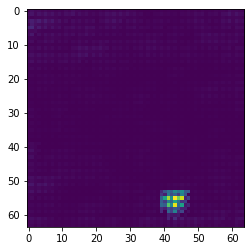

In [41]:
# before dooing this we need to change the riemann.py in the scrips tag.
# there we have hardcoded 28 when it is rally 64

z_sample = np.random.normal(size=latent_dim).reshape(1, latent_dim)
print("z_sampel", z_sample.shape)
_,x_decoded= rbf_decoder.predict(z_sample, batch_size=batch_size)
print("x_decoded.shape", x_decoded.shape)
plt.imshow(np.squeeze(x_decoded))
#decoder.summary()
model_input = rbf_decoder.inputs[0]
model_output = rbf_decoder.outputs[0]
model_ouput_var = rbf_decoder.outputs[1]
print(model_input, model_output)
print(model_input[:,0], model_output)
print("num_layer",model_input[:,:].shape, model_output[:,0].shape )
#output_dim = model_output.shape[1]
#print("output_dim", model_output.shape[1])
#J=[tf.gradients(model_output[:, _], model_input)[0] for _ in range(64)]
#print(J)
#J = tf.stack(J, axis=1)  # batch x output x latent
print("")
print("Done")
print("")
session = tf.Session()
session.run(tf.global_variables_initializer())
rmetric = RiemannianMetric(x=model_output, z=model_input, session=session)
rmetric.create_tf_graph(output_dim=64)

rmetric_var = RiemannianMetric(x=model_ouput_var, z=model_input, session=session)
rmetric_var.create_tf_graph(output_dim=64)
print("doneee") 




In [42]:
# claculate the magnitude for each point
print(X_train.shape, X_recon.shape, pca.shape)

num = 100
def calc_magnitude(rmetric, rmetric_var, session, data, verbose=False):
    G = session.run(rmetric.G, {rmetric.z: data})
    G_var = session.run(rmetric_var.G, {rmetric_var.z:data})
    MF = np.sqrt(np.linalg.det(G + G_var))
    if verbose:
        print("G: ", np.count_nonzero(G), G.shape)
        print("G_var: ", np.count_nonzero(G), G.shape)
        print("MF: ", np.count_nonzero(MF), MF.shape)
    return MF
calc_magnitude(rmetric, rmetric_var, session, X_recon[:num], verbose=True)
#plt.figure()
#print(pca[:num,0].shape)
#plt.scatter(pca[:num,0], pca[:num,1], c=mf)
#plt.show()


(1000, 64, 64, 1) (1000, 2) (1000, 2)
G:  400 (100, 2, 2)
G_var:  400 (100, 2, 2)
MF:  100 (100,)


array([153.34338  ,  81.24926  ,  51.796432 ,  98.2283   , 127.60563  ,
       136.29495  , 136.15898  , 133.05228  , 130.7554   ,  18.476261 ,
       177.35791  , 104.79865  ,  83.71554  , 194.96413  ,  54.01639  ,
       246.78241  , 145.77301  ,  79.751434 ,  36.234913 ,  74.08886  ,
        49.082657 ,  33.23004  ,  39.0074   ,  25.411272 ,  15.21235  ,
        13.720321 ,  48.190647 ,  19.91441  , 162.53664  , 216.02014  ,
        29.287664 ,  33.215073 ,  40.391075 ,   9.713899 ,  25.761604 ,
        23.651463 ,  24.657486 ,  15.631111 ,  15.390553 ,  10.647201 ,
         1.9302198,  33.875774 ,   2.554463 ,  60.364437 ,  69.086365 ,
        18.278778 ,   3.059659 , 215.97975  , 236.8426   ,  73.97368  ,
        79.23145  , 264.21222  , 209.62906  ,  70.07075  ,  61.728634 ,
       149.05855  , 144.62303  ,  56.569027 ,  26.684866 ,  18.767595 ,
        17.55068  ,  17.874178 ,   6.687784 ,   5.630543 ,  25.681293 ,
         4.196427 ,   4.671072 ,  18.733498 ,  43.793633 ,  26.4

1.2191268 0.12137113
input shape (1000, 2)

grid_inp [[-1.64485363  1.64485363]
 [-1.03643339  1.64485363]
 [-0.67448975  1.64485363]
 [-0.38532047  1.64485363]
 [-0.12566135  1.64485363]
 [ 0.12566135  1.64485363]
 [ 0.38532047  1.64485363]
 [ 0.67448975  1.64485363]
 [ 1.03643339  1.64485363]
 [ 1.64485363  1.64485363]] [[-1.64485363 -1.64485363]
 [-1.03643339 -1.64485363]
 [-0.67448975 -1.64485363]
 [-0.38532047 -1.64485363]
 [-0.12566135 -1.64485363]
 [ 0.12566135 -1.64485363]
 [ 0.38532047 -1.64485363]
 [ 0.67448975 -1.64485363]
 [ 1.03643339 -1.64485363]
 [ 1.64485363 -1.64485363]]
(100, 2)
(100, 64, 64, 1)


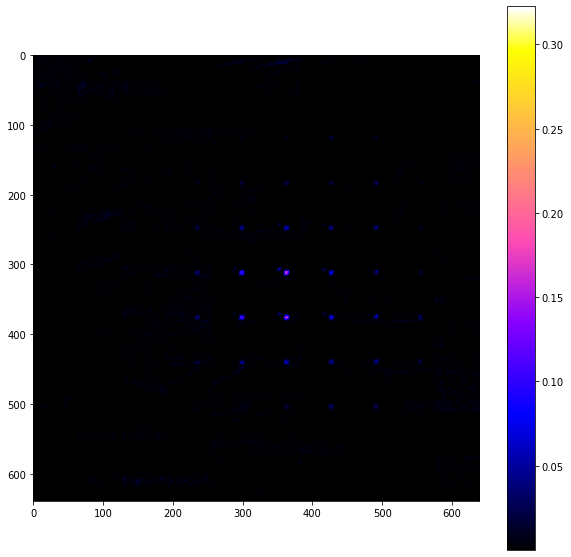

In [43]:
# Display a 2D manifold of the digits
print(X_recon.std(), X_recon.mean())
n = 10  # figure with 20x20 digits
figure = np.zeros((patch_size * n, patch_size * n))

# 1. create grid form training pca space 
print("input shape", pca.shape)
#x_min, x_max = pca[:, 0].min() - 1, pca[:, 0].max() + 1
#y_min, y_max = pca[:, 1].min() - 1,pca[:, 1].max() + 1
#xx, yy = np.meshgrid(np.linspace(x_min, x_max, n),
#                    np.linspace(y_min, y_max, n))
xxx = np.flip(norm.ppf(np.linspace(0.05, 0.95, n)))
yyy = norm.ppf(np.linspace(0.05, 0.95, n))
#print(xxx[:5], yyy[:5])
grid_inp = np.empty([n*n, 2])
ii=0
for i, yi in enumerate(xxx):
    for j, xi in enumerate(yyy):
        grid_inp[ii] = np.asarray([xi, yi])
        ii+=1
print()
print("grid_inp", grid_inp[:10], grid_inp[-10:])

#print(x_min, y_max, y_min, y_max, xx.shape, yy.shape)
# convert to actual coordinate format 
#grid_inp = np.c_[xx.ravel(), yy.ravel()]   
#print(grid_inp.shape, grid_inp[0:10])

# 2. inverce pca it to get correct latent dims
if use_pca:
    latent_grid_inp = pca_model.inverse_transform(grid_inp)
else: latent_grid_inp = grid_inp
print(latent_grid_inp.shape)

# 3. decode each latent vector
_,latent_grid_out = rbf_decoder.predict(latent_grid_inp)
print(latent_grid_out.shape)
# 4. plot it in grid
indx = 0
for i, yi in enumerate(xxx):
    for j, xi in enumerate(yyy):
        z_sample = np.squeeze(latent_grid_out[indx])
        figure[i * patch_size: (i + 1) * patch_size,
               j * patch_size: (j + 1) * patch_size] = z_sample
        indx+=1

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gnuplot2')
plt.colorbar()
plt.show()  

In [50]:
# Now we want to plot the riemann metric to display the distorion when goin from Z --> X
# This is more complicated as the datapoints are not in 2d when we encode. 
# The goal is to look how much the datapoint in z actually diverge by looking at how much they change from Z --> X
# We can rom this assume that high divergence in this process contribute to more sditance among the points. 
# By plotting it we can infer geometry to the latent space. 

# If this was 2d we could easily calc the metric for each gridpoint in the 2d plane. 
# But when our latet space is in more (e.g 16) dimentions we cannot pick such a grid
# But, we can project the 16 dimensjons on to the 2d GRID BY EITHER pca, T_SNE(not good for distances) or UMAP. 
# Here, seeing these are symetrical (meaning map from x->z and z-> x will give same x ) we assume that 
# we can 
    # 1. choose a. grid from the training pca (where the datapoints so far have landed and most new will), 
    # 2. Calc the inverse PCA for all these, therby finding the 16 dim vector corresponding to this "cell"
    # 3. calc riemann magnitude over this, and seeing we know the posision in 2d for the 16d vecotr, we can plot it in the 2d PCA space. 
    # 4. plot it in a 2d map with the scatterplots 

# 1. create grid form training pca space 
# here we use the same grid as the labove cell 
from tqdm import trange

#print("input shape", pca.shape)
############# #commment out for exaclyt same ploat as above
h = 800#0.3  # step size in the mesh
x_min, x_max = pca[:, 0].min() - 1, pca[:, 0].max() + 1
y_min, y_max = pca[:, 1].min() - 1,pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, h),
                   np.linspace(y_min, y_max, h))
print(x_min, y_max, y_min, y_max, xx.shape, yy.shape)
# convert to actual coordinate format 
grid_inp = np.c_[xx.ravel(), yy.ravel()]   
##########
print(grid_inp.shape)
print("grid_inp", grid_inp[:10], grid_inp[-10:])




# 2. inverce pca it to get correct latent dims 
# here we use the same pca gird as the above cell 
#######commment out for exaclyt same ploat as above
if use_pca:
    latent_grid_inp = pca_model.inverse_transform(grid_inp)
else: latent_grid_inp = grid_inp
############
print(latent_grid_inp.shape)
grid_inp_shape = latent_grid_inp.shape[0]
# 3. calc riemann magnitude for each latend vector 
# need to calc overflow as it needs to fit the batch size
overflow = math.ceil(grid_inp_shape/batch_size)
# need to batch up grid in batch sizes... 
#mf = session.run(rmetric.MF, {rmetric.z: latent_grid_inp})
mf = np.empty([overflow*batch_size]) 

for i in trange(overflow):
    rm = grid_inp_shape - batch_size*i
    if rm< batch_size:
        grid_batch = np.zeros((batch_size, 2))
        grid_batch[0:rm] = latent_grid_inp[i*batch_size:i*batch_size+batch_size]
    else:
        grid_batch = latent_grid_inp[i*batch_size:i*batch_size+batch_size]
    #print(rm, i*batch_size,i*batch_size+batch_size)
    mf[i*batch_size:i*batch_size+batch_size]  = calc_magnitude(rmetric , rmetric_var, session, grid_batch)

# now we clip the overflow away 
mf = mf[:grid_inp_shape]


  0%|          | 2/40000 [00:00<36:53, 18.07it/s]

-8.250724792480469 7.382573127746582 -7.340385437011719 7.382573127746582 (800, 800) (800, 800)
(640000, 2)
grid_inp [[-8.25072479 -7.34038544]
 [-8.22904742 -7.34038544]
 [-8.20737006 -7.34038544]
 [-8.18569269 -7.34038544]
 [-8.16401532 -7.34038544]
 [-8.14233795 -7.34038544]
 [-8.12066058 -7.34038544]
 [-8.09898322 -7.34038544]
 [-8.07730585 -7.34038544]
 [-8.05562848 -7.34038544]] [[8.87439603 7.38257313]
 [8.8960734  7.38257313]
 [8.91775076 7.38257313]
 [8.93942813 7.38257313]
 [8.9611055  7.38257313]
 [8.98278287 7.38257313]
 [9.00446024 7.38257313]
 [9.0261376  7.38257313]
 [9.04781497 7.38257313]
 [9.06949234 7.38257313]]
(640000, 2)


100%|██████████| 40000/40000 [32:41<00:00, 20.39it/s]


mf grid (640000,) 640000
0.06514333188533783 333.4039001464844
-2.5229706758824775 1.1861300323475876


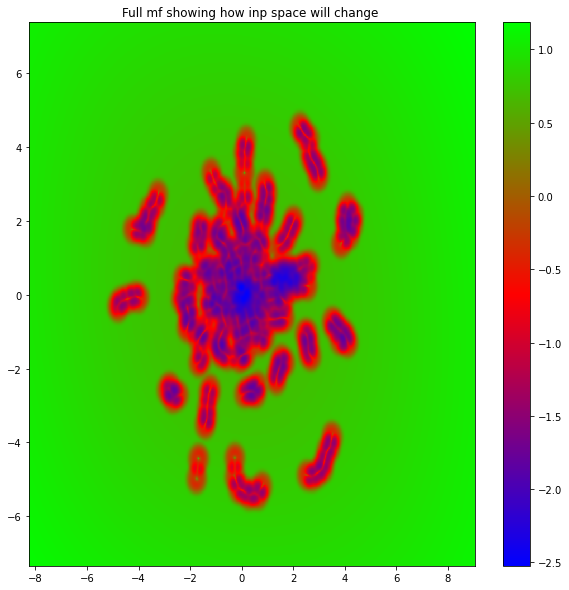

In [58]:
#np.save(output_folder+ "/mf_original.npy", mf)
#mf = np.load(output_folder+ "/mf_original.npy")

#mf = calc_magnitude(rmetric , rmetric_var, session, latent_grid_inp)
#mf = np.nan_to_num(mf)
print("mf grid", mf.shape,  np.count_nonzero(mf))
# 4. plot it in a scatterplot 
# Put the result into a color plot
########commment out for exaclyt same ploat as above
Z = mf.reshape(xx.shape)
#Z = mf.reshape(n, n)
#######

print(Z.min(), Z.max())
def normalizeData(data):
      return (data - np.min(data)) / (np.max(data) - np.min(data))
#Z = normalizeData(Z)
#print(Z.min(), Z.max())
#Z = np.log10(1/(Z))
#Z = np.log10(Z)
#Z = 1/Z

Z = np.log10(1/Z)
print(Z.min(), Z.max())

plt.figure(figsize=(10,10))
#plt.imshow(Z, interpolation="bilinear", cmap="brg")
plt.pcolormesh(xx, yy, Z, cmap="brg")
#plt.scatter(X_recon[:,0], X_recon[:, 1], s=1, color="yellow")

#plot actuals
plt.title("Full mf showing how inp space will change ")
plt.colorbar()
plt.show()




In [101]:
# save data to be used in enxt notebook
np.save(output_folder+ "/mf_original.npy", Z)
np.save(output_folder+ "/xx.npy", xx)
np.save(output_folder+ "/yy.npy", yy)